<a href="https://colab.research.google.com/github/stratoskar/Path_Based_Traffic_Flow_Prediction/blob/main/Python_Code%20/Experiments%20With%20Weather%20Data/1_Find_Best_Traffic_Flow_Model_Using_Weather_Data_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**In this section of the code, we train two discrete Machine Learning models with the purpose of forecasting traffic flow along every path. We use additional weather data to compare the results with the model trained when their use was absent.**

The models that we use are: Long Short-Term Memory (LSTM) Recurent Neural Network (RNN) and an XGBoost regressor.

In [1]:
# Disable warnings
import warnings
warnings.filterwarnings('ignore')

# Standard library imports
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Handle timestamp data types
from datetime import datetime, timedelta

In [2]:
# Access google drive location
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Define the path with the data that we are interested in
PATH = '/content/drive/MyDrive/Paper/Timeseries/traffic_flow_SPQ.csv'

**Prepare the dataset**

In [4]:
# Read the time series dataset
traffic_flow = pd.read_csv(PATH)

# This list contains the column names
columns = ["Taxi ID", "Traj ID", "Path", "Length"]

# Generate the columns for the dataset
i = 4

while(True):
    # If it is the first iteration, append the initial timestamp
    if i == 4:
        columns.append(pd.to_datetime('2008-05-17 10:00:04'))
    else:
        # Append the next timestamp by adding 30 minutes (1800 seconds) to the previous timestamp
        columns.append(columns[i-1] + timedelta(seconds=1800))

    # Check if the current timestamp is greater than or equal to a specific end timestamp
    if (columns[i] >= pd.to_datetime('2008-06-10 09:30:04')):

        # Break out of the loop if the condition is met
        break

    # Increment the counter
    i += 1

# Delete the last timestamp
columns.pop()

# Assign new column names to the dataframe
traffic_flow.columns = columns

In [5]:
# Print first 2 rows of dataframe
traffic_flow.head(2)

,Taxi ID,Traj ID,Path,Length,2008-05-17 10:00:04,2008-05-17 10:30:04,2008-05-17 11:00:04,2008-05-17 11:30:04,2008-05-17 12:00:04,2008-05-17 12:30:04,...,2008-06-10 04:30:04,2008-06-10 05:00:04,2008-06-10 05:30:04,2008-06-10 06:00:04,2008-06-10 06:30:04,2008-06-10 07:00:04,2008-06-10 07:30:04,2008-06-10 08:00:04,2008-06-10 08:30:04,2008-06-10 09:00:04
0,304,1291,"[734004334, 734004334, 734004334, 734004334, 7...",17,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,344,433,"[514685521, 514685521, 306338109, 306338109, 3...",7,11,7,6,3,0,1,...,0,0,0,0,0,0,2,2,0,0


In [6]:
# Reshape the data from wide format to long format
id_cols = ['Taxi ID','Traj ID', 'Path', 'Length']
time_cols = traffic_flow.iloc[:,2:].columns
traffic_flow = traffic_flow.melt(id_vars=id_cols, value_vars=time_cols, var_name='Time Column', value_name='Traffic Flow')
traffic_flow['Time Column'] = pd.to_datetime(traffic_flow['Time Column'])

# Sort rows by Path and Time
traffic_flow.sort_values(by=['Path','Time Column'],inplace=True)

In [7]:
# Convert 'Path' column to numerical
# Use label encoder
from sklearn.preprocessing import LabelEncoder

# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder on the 'Path' column
traffic_flow['Path'] = label_encoder.fit_transform(traffic_flow['Path'])

# Sort the data based in Path column
traffic_flow = traffic_flow.sort_values(by=['Path','Time Column'])

In [8]:
# Select only data of May, as we have only weather data from 2008-05-01 to 2008-05-31 time period
traffic_flow = traffic_flow[traffic_flow['Time Column']<'2008-06-01']

In [9]:
# Print dataframe
traffic_flow = traffic_flow.reset_index(drop=True)

In [10]:
traffic_flow

,Taxi ID,Traj ID,Path,Length,Time Column,Traffic Flow
0,108,5,0,20,2008-05-17 10:00:04,0
1,108,5,0,20,2008-05-17 10:30:04,0
2,108,5,0,20,2008-05-17 11:00:04,0
3,108,5,0,20,2008-05-17 11:30:04,1
4,108,5,0,20,2008-05-17 12:00:04,0
...,...,...,...,...,...,...
69995,168,547,99,2,2008-05-31 21:30:04,0
69996,168,547,99,2,2008-05-31 22:00:04,0
69997,168,547,99,2,2008-05-31 22:30:04,0
69998,168,547,99,2,2008-05-31 23:00:04,0


**Read and preprocess the weather data**
In the weather dataset of San Francisco area, there are many columns that are useless for our research. We just drop them and preprocess the dataset with weather information.

In [11]:
# Define the path of weather data
path2 = '/content/drive/MyDrive/Paper/Dataset/Weather/weather_data.csv'

# Read weather data
weather_data = pd.read_csv(path2,sep=',')

In [12]:
# Drop unecessary columns

# Columns kept: temperature, humidity, windspeed and dew
weather_data = weather_data.drop(['name','conditions','visibility','feelslike','sealevelpressure','precip','precipprob','preciptype',
                                  'snow','snowdepth','windgust','winddir','cloudcover',
                                  'solarradiation','solarenergy','uvindex','severerisk','stations','icon'],axis=1)

In [13]:
# Convert datetime column to appropriate format
weather_data['datetime'] = pd.to_datetime(weather_data['datetime'])

In [14]:
# Connect two dataframes, "traffic_flow" and "weather data"
traffic_flow.set_index('Time Column', inplace=True)
weather_data.set_index('datetime', inplace=True)

# Resample the 'weather_data' dataset to 30-minute intervals and forward-fill the missing values
weather_data = weather_data.resample('30T').ffill()
weather_data.index= weather_data.index  + timedelta(seconds=4)

# Merge the time_series and weather_data_resampled datasets based on their indexes
traffic_flow = traffic_flow.merge(weather_data, left_index=True, right_index=True)

In [15]:
# Reset index in dataframe
traffic_flow = traffic_flow.reset_index()
traffic_flow.rename(columns={'index': 'Time Column'}, inplace=True)

**Feature Creation From Time Information**

In this step we define some features based on time series timestamps.
- Day, day of week, hour and minute features derive directly from the timestamp column of the dataset.
- Hour_sin and Hour_cos columns transform the hour values into a cyclic representation, where the values range from -1 to 1. This transformation is used in time series analysis to capture the periodic patterns or cyclical nature of time-related data.
- Use also the 3_hour_interval to describe, in which interval of the day data refer to.

In [16]:
### Extract timestamp information to different columns ###
traffic_flow['hour'] = traffic_flow['Time Column'].dt.hour
traffic_flow['dayofweek'] = traffic_flow['Time Column'].dt.dayofweek
traffic_flow['day'] = traffic_flow['Time Column'].dt.day
traffic_flow['minute'] = traffic_flow['Time Column'].dt.minute

### Circular Encoding for cyclic time features ###
traffic_flow['hour_sin'] = np.sin(2 * np.pi * traffic_flow['hour'] / 24)
traffic_flow['hour_cos'] = np.cos(2 * np.pi * traffic_flow['hour'] / 24)

traffic_flow['day_of_week_sin'] = np.sin(2 * np.pi * traffic_flow['dayofweek'] / 7)
traffic_flow['day_of_week_cos'] = np.cos(2 * np.pi * traffic_flow['dayofweek'] / 7)

traffic_flow['day_sin'] = np.sin(2 * np.pi * traffic_flow['day'] / 31)
traffic_flow['day_cos'] = np.cos(2 * np.pi * traffic_flow['day'] / 31)

traffic_flow['minute_sin'] = np.sin(2 * np.pi * traffic_flow['minute'] / 60)
traffic_flow['minute_cos'] = np.cos(2 * np.pi * traffic_flow['minute'] / 60)

In [17]:
# Define a custom function to determine the three-hour interval, based in timestamp hour information
def get_3hour_interval(hour):
    if hour in [0, 1, 2]:
        return 1
    elif hour in [3, 4, 5]:
        return 2
    elif hour in [6, 7, 8]:
        return 3
    elif hour in [9, 10, 11]:
        return 4
    elif hour in [12, 13, 14]:
        return 5
    elif hour in [15, 16, 17]:
        return 6
    elif hour in [18, 19, 20]:
        return 7
    elif hour in [21, 22, 23]:
        return 8
    else:
        return None

# Apply the custom function on the data to create the '3hour_interval' column
traffic_flow['3hour_interval'] = traffic_flow['hour'].apply(get_3hour_interval)

In [18]:
traffic_flow.head(5)

,Time Column,Taxi ID,Traj ID,Path,Length,Traffic Flow,temp,dew,humidity,windspeed,...,minute,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,day_sin,day_cos,minute_sin,minute_cos,3hour_interval
0,2008-05-17 10:00:04,108,5,0,20,0,21.4,11.8,54.07,12.1,...,0,0.5,-0.866025,-0.974928,-0.222521,-0.299363,-0.954139,0.0,1.0,4
1,2008-05-17 10:00:04,176,259,1,15,0,21.4,11.8,54.07,12.1,...,0,0.5,-0.866025,-0.974928,-0.222521,-0.299363,-0.954139,0.0,1.0,4
2,2008-05-17 10:00:04,331,515,2,16,1,21.4,11.8,54.07,12.1,...,0,0.5,-0.866025,-0.974928,-0.222521,-0.299363,-0.954139,0.0,1.0,4
3,2008-05-17 10:00:04,47,361,3,20,13,21.4,11.8,54.07,12.1,...,0,0.5,-0.866025,-0.974928,-0.222521,-0.299363,-0.954139,0.0,1.0,4
4,2008-05-17 10:00:04,176,99,4,6,26,21.4,11.8,54.07,12.1,...,0,0.5,-0.866025,-0.974928,-0.222521,-0.299363,-0.954139,0.0,1.0,4


In [19]:
print(f"Earlier timestamp in traffic_flow dataframe is: {traffic_flow['Time Column'].min()}")
print(f"Latest timestamp in traffic_flow dataframe is: {traffic_flow['Time Column'].max()}")

Earlier timestamp in traffic_flow dataframe is: 2008-05-17 10:00:04
Latest timestamp in traffic_flow dataframe is: 2008-05-31 23:00:04


<Axes: >

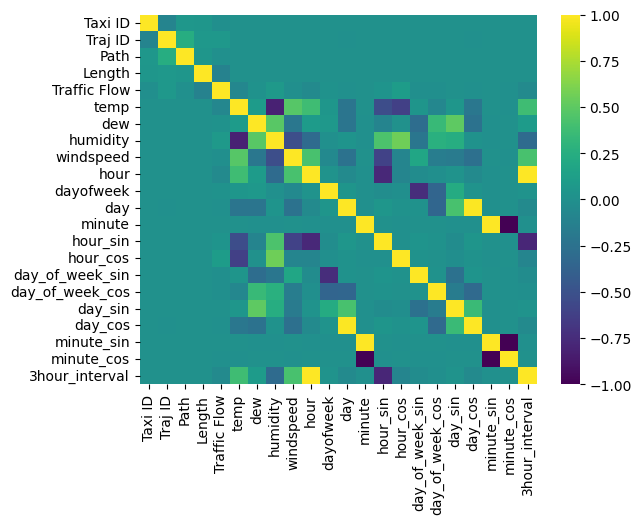

In [20]:
# Use a correlation matrix to show correlations among attributes in the dataset
sns.heatmap(traffic_flow.corr(),cmap='viridis')

In [21]:
# Define a list with the items to be removed
removable_items = ['Record 1(t)', 'Time Column', 'Taxi ID', 'Traj ID', 'Length', 'Traffic Flow', 'hour', 'hour_sin','day_of_week_cos', 'dayofweek', 'day', 'minute', 'minute_cos']

#### **Find the Optimum Sliding Window Length**

In [22]:
# Sort the time series data
traffic_flow.sort_values(by=['Path','Time Column'], inplace=True)

In [23]:
# Import libraries to use XGBoost model
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [24]:
# Import libraries to use the LSTM Neural Network algorithm
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
import tensorflow as tf

# Min Max Scaler
from sklearn.preprocessing import MinMaxScaler

In [25]:
# Use Regression Evaluation Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

**Create function that converts the data into a supervised problem**

Consider for each path n_in timesteps of observations in the past, in order to predict the n_out timesteps in the future.

In [26]:
def series_to_supervised(data, n_in=1, n_out=1):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()

    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('Record %d(t-%d)' % (j+1, i)) for j in range(n_vars)]

    # Generate sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('Record %d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('Record %d(t+%d)' % (j+1, i)) for j in range(n_vars)]

    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    return agg

def generate_X_y_pairs(data, n_in=1, n_out=1):
    """
    Convert the training data into a supervised dataset. Create X,y pairs of the traffic column information.
    Then, concatenate the rest of the columns.
    """
    new_data = pd.DataFrame()

    # Iterate over unique values in the 'Path' column
    for item in data['Path'].unique():
        # Call function only for the 'Traffic Flow' column
        supervised_traffic_flow = series_to_supervised(pd.DataFrame(data[data['Path'] == item]['Traffic Flow']), n_in, n_out)

        # Concatenate the rest of the columns
        supervised_traffic_flow = pd.concat([supervised_traffic_flow, traffic_flow[traffic_flow['Path'] == item]], axis=1)

        new_data = pd.concat([new_data, supervised_traffic_flow])

    # Drop rows with NaN values
    new_data.dropna(inplace=True)
    return new_data

##### Sliding Window Length Equals to 2

In [27]:
# Define Window Length
optimum_lookback = 2

In [28]:
# Define train data
train= traffic_flow.loc[traffic_flow['Time Column'] < '2008-05-29']

# Define test data
test = traffic_flow.loc[traffic_flow['Time Column'] >= '2008-05-29']

In [29]:
# Convert train and test data to supervised problem based in the optimum lookback step we defined above.
train = generate_X_y_pairs(train, optimum_lookback)
test = generate_X_y_pairs(test, optimum_lookback)

In [30]:
# Add rolling mean information
train['rolling_mean'] = 0
test['rolling_mean'] = 0

# Add rolling var information
train['rolling_var'] = 0
test['rolling_var'] = 0

# Calculate rolling mean of window
train['rolling_mean'] = train.iloc[:,0:2].mean(axis=1)
test['rolling_mean'] = test.iloc[:,0:optimum_lookback].mean(axis=1)

# Calculate rolling variance of window
train['rolling_var'] = train.iloc[:, 0:optimum_lookback].var(axis=1)
test['rolling_var'] = test.iloc[:, 0:optimum_lookback].var(axis=1)

In [31]:
# Define features
features = train.drop(removable_items,axis=1).columns

# Define labels
labels = ['Record 1(t)']

# Create X_train and y_train data sets
X_train = train[features]
y_train = train[labels]

# Create X_test and y_test data sets
X_test = test[features]
y_test = test[labels]

**Apply GridSearchCV**

Use a 3-fold K-fold cross-validation was used for learning the optimum hyperparameters for the XGBoost algorithm.

In [32]:
# Import Grid Search library
from sklearn.model_selection import GridSearchCV

In [33]:
# Tune hyperparameters using XGboost
xgb_params = {
    "n_estimators": [100],
    "learning_rate": [0.1],
    "max_depth": [3,6,9],
    "objective":['reg:squarederror'],
    "gamma": [0,0.1],
    "reg_lambda": [0,1],
    'reg_alpha': [0, 0.1]
}

# Define GridSearchCV object
xgb_grid = GridSearchCV(xgb.XGBRegressor(),
                        xgb_params,cv=3,
                        scoring= "neg_mean_squared_error")

# Train on train data using 3 fold Cross Validation
xgb_grid.fit(X_train,y_train,
             early_stopping_rounds=5,
             eval_set=[(X_train, y_train), (X_test,y_test)],
             eval_metric='rmse')

# print the best hyperparameters and corresponding score
print("Best Hyperparameters: ", xgb_grid.best_params_)
print("Best Score: ", xgb_grid.best_score_)

[0]	validation_0-rmse:4.58107	validation_1-rmse:4.50583
[1]	validation_0-rmse:4.26298	validation_1-rmse:4.18637
[2]	validation_0-rmse:3.98530	validation_1-rmse:3.91207
[3]	validation_0-rmse:3.74203	validation_1-rmse:3.67107
[4]	validation_0-rmse:3.53157	validation_1-rmse:3.46369
[5]	validation_0-rmse:3.34920	validation_1-rmse:3.28516
[6]	validation_0-rmse:3.19368	validation_1-rmse:3.13353
[7]	validation_0-rmse:3.06015	validation_1-rmse:3.00343
[8]	validation_0-rmse:2.94598	validation_1-rmse:2.89404
[9]	validation_0-rmse:2.85013	validation_1-rmse:2.80179
[10]	validation_0-rmse:2.76855	validation_1-rmse:2.72474
[11]	validation_0-rmse:2.69993	validation_1-rmse:2.66064
[12]	validation_0-rmse:2.64002	validation_1-rmse:2.60367
[13]	validation_0-rmse:2.59059	validation_1-rmse:2.55649
[14]	validation_0-rmse:2.54989	validation_1-rmse:2.51956
[15]	validation_0-rmse:2.51699	validation_1-rmse:2.49056
[16]	validation_0-rmse:2.48797	validation_1-rmse:2.46363
[17]	validation_0-rmse:2.46440	validation

**Train an XGboost model**

We will fit all the data in this model using the optimum parameters we found above.

In [34]:
# Define XGBoost regressor
reg = xgb.XGBRegressor(
    reg_lambda = xgb_grid.best_params_['reg_lambda'],
    reg_alpha = xgb_grid.best_params_['reg_alpha'],
    learning_rate = xgb_grid.best_params_['learning_rate'],
    max_depth = xgb_grid.best_params_['max_depth'],
    n_estimators = 100,
    gamma = xgb_grid.best_params_['gamma'],
    objective = xgb_grid.best_params_['objective'],
    early_stopping_rounds = 5
)

# Train the XGBoost model with feature weights (use validation set on test data)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test,y_test)],
        verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=5,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Make predictions on the test set

In [35]:
# Make predictions on the X_test set
y_pred_xgboost = reg.predict(X_test)

In [36]:
# Calculate the MAE of XGBoost model
mae_xgboost = mean_absolute_error(y_test, y_pred_xgboost)
print("Mae is: ",mae_xgboost)

# Calculate RMSE score of XGBoost model
rmse_xgboost = mean_squared_error(y_test, y_pred_xgboost, squared=False)
print("RMSE score:", rmse_xgboost)

Mae is:  1.379464659992579
RMSE score: 2.2992430014514533


**Train LSTM for time series forecasting**

Use the same train and test sets as in the XGBoost model. In order to create more accurate predictions, we scale those two sets before giving them as input to the LSTM Recurrent Neural Network model.

In [37]:
# Scale the data
scaler = MinMaxScaler()
X_tr = scaler.fit_transform(X_train)
X_te = scaler.fit_transform(X_test)

y_tr = scaler.fit_transform(y_train)
y_te = scaler.fit_transform(y_test)

In [38]:
# Create 3D train set for LSTM
trainX = []
trainY = []

for i in range(len(X_tr)):
    trainX.append(X_tr[i:i+1,:])

for i in range(len(y_tr)):
    trainY.append(y_tr[i:i+1,:])

trainX, trainY = np.array(trainX), np.array(trainY)

In [39]:
# Create 3D test set for LSTM
testX = []
testY = []

for i in range(len(X_te)):
    testX.append(X_te[i:i+1,:])

for i in range(len(y_te)):
    testY.append(y_te[i:i+1,:])

testX, testY = np.array(testX), np.array(testY)

In the LSTM model, we include dense layers to capture more complex non linear patterns and dropout layers to prevent overfitting.

In [40]:
# Define LSTM model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(25, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(12, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

# Additional Dense layers
model.add(Dense(6, activation='relu'))
model.add(Dense(3, activation='linear'))

# Output layer
model.add(Dense(trainY.shape[1]))

# Add early stopping mechanism
early_stopping = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

In [41]:
# Compile LSTM model
model.compile(optimizer='adam', loss='mse')

In [42]:
# Fit model on training data
history = model.fit(trainX, trainY,
          epochs=50,
          batch_size=len(trainX)//100,
          validation_data=(testX,testY),
          callbacks=[early_stopping])

Epoch 1/50
100/100 [==============================] - 12s 43ms/step - loss: 0.0082 - val_loss: 0.0120
Epoch 2/50
100/100 [==============================] - 2s 20ms/step - loss: 0.0041 - val_loss: 0.0032
Epoch 3/50
100/100 [==============================] - 4s 36ms/step - loss: 0.0027 - val_loss: 0.0032
Epoch 4/50
100/100 [==============================] - 2s 20ms/step - loss: 0.0025 - val_loss: 0.0032
Epoch 5/50
100/100 [==============================] - 2s 16ms/step - loss: 0.0023 - val_loss: 0.0031
Epoch 6/50
100/100 [==============================] - 3s 29ms/step - loss: 0.0023 - val_loss: 0.0035
Epoch 7/50
100/100 [==============================] - 1s 12ms/step - loss: 0.0022 - val_loss: 0.0035
Epoch 8/50
100/100 [==============================] - 5s 50ms/step - loss: 0.0022 - val_loss: 0.0034
Epoch 9/50
100/100 [==============================] - 1s 12ms/step - loss: 0.0021 - val_loss: 0.0038
Epoch 10/50
100/100 [==============================] - 2s 18ms/step - loss: 0.0021 - val_l

In [43]:
# Evaluate model on test data
loss_lstm = model.evaluate(testX, testY)
print("Test Loss:", loss_lstm)

441/441 [==============================] - 5s 10ms/step - loss: 0.0031
Test Loss: 0.0031471720430999994


In [44]:
# Predict on test data
y_pred_lstm = model.predict(testX)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm.reshape(-1,1))

441/441 [==============================] - 6s 12ms/step


Evaluate the LSTM model

In [45]:
# Calculate the MAE score of LSTM model
mae_lstm = mean_absolute_error(scaler.inverse_transform(testY.reshape(-1,1)),y_pred_lstm)
print("Mae LSTM is: ",mae_lstm)

# Calculate the RMSE score of LSTM model
rmse_lstm = mean_squared_error(scaler.inverse_transform(testY.reshape(-1,1)), y_pred_lstm, squared=False)
print("RMSE LSTM score:", rmse_lstm)

Mae LSTM is:  1.5280657241171134
RMSE LSTM score: 2.4683852405478373


Add in the same dataframe the RMSE and MAE scores of each model, in order to compare them

In [46]:
# Create dataframe with scores (length == 2)
scores = pd.DataFrame(columns=['Model','RMSE Score','MAE Score'])

# Define rows for dataframe
new_row = {'Model': 'XGBoost', 'RMSE Score': rmse_xgboost, 'MAE Score': mae_xgboost}
new_row1 = {'Model': 'LSTM', 'RMSE Score': rmse_lstm, 'MAE Score': mae_lstm}

# Add rows to dataframe
scores = scores.append(new_row, ignore_index=True)
scores = scores.append(new_row1, ignore_index=True)

In [47]:
scores # length is 2

,Model,RMSE Score,MAE Score
0,XGBoost,2.299243,1.379465
1,LSTM,2.468385,1.528066


In [48]:
# Save XGBoost model to a file
reg.save_model('/content/drive/MyDrive/Paper/Models/xgboost_traffic_flow_length-'+str(optimum_lookback)+'.model')

In [49]:
# Save the LSTM model
model.save("/content/drive/MyDrive/Paper/Models/LSTM-length-"+str(optimum_lookback)+".h5")

##### Sliding Window Length Equals to 3

In [50]:
# Define Window Length
optimum_lookback = 3

In [51]:
# Define train data
train= traffic_flow.loc[traffic_flow['Time Column'] < '2008-05-29']

# Define test data
test = traffic_flow.loc[traffic_flow['Time Column'] >= '2008-05-29']

In [52]:
# Convert train and test data to supervised problem based in the optimum lookback step we defined above.
train = generate_X_y_pairs(train, optimum_lookback)
test = generate_X_y_pairs(test, optimum_lookback)

In [53]:
# Add rolling mean information
train['rolling_mean'] = 0
test['rolling_mean'] = 0

# Add rolling var information
train['rolling_var'] = 0
test['rolling_var'] = 0

# Calculate rolling mean of window
train['rolling_mean'] = train.iloc[:,0:2].mean(axis=1)
test['rolling_mean'] = test.iloc[:,0:optimum_lookback].mean(axis=1)

# Calculate rolling variance of window
train['rolling_var'] = train.iloc[:, 0:optimum_lookback].var(axis=1)
test['rolling_var'] = test.iloc[:, 0:optimum_lookback].var(axis=1)

In [54]:
# Define features
features = train.drop(removable_items,axis=1).columns

# Define labels
labels = ['Record 1(t)']

# Create X_train and y_train data sets
X_train = train[features]
y_train = train[labels]

# Create X_test and y_test data sets
X_test = test[features]
y_test = test[labels]

**Apply GridSearchCV**

Use a 3-fold K-fold cross-validation was used for learning the optimum hyperparameters for the XGBoost algorithm.

In [55]:
xgb_params = {
    "n_estimators": [100],
    "learning_rate": [0.1],
    "max_depth": [3,6,9],
    "objective":['reg:squarederror'],
    "gamma": [0,0.1],
    "reg_lambda": [0,1],
    'reg_alpha': [0, 0.1]
}

# Define GridSearchCV object
xgb_grid = GridSearchCV(xgb.XGBRegressor(),
                        xgb_params,cv=3,
                        scoring= "neg_mean_squared_error")

# Train on train data using 3 fold Cross Validation
xgb_grid.fit(X_train,y_train,
             early_stopping_rounds=5,
             eval_set=[(X_train, y_train), (X_test,y_test)],
             eval_metric='rmse')

# print the best hyperparameters and corresponding score
print("Best Hyperparameters: ", xgb_grid.best_params_)
print("Best Score: ", xgb_grid.best_score_)

[0]	validation_0-rmse:4.59273	validation_1-rmse:4.51405
[1]	validation_0-rmse:4.28164	validation_1-rmse:4.20766
[2]	validation_0-rmse:4.00767	validation_1-rmse:3.93736
[3]	validation_0-rmse:3.76879	validation_1-rmse:3.69682
[4]	validation_0-rmse:3.55830	validation_1-rmse:3.49054
[5]	validation_0-rmse:3.37818	validation_1-rmse:3.31094
[6]	validation_0-rmse:3.21991	validation_1-rmse:3.15420
[7]	validation_0-rmse:3.08415	validation_1-rmse:3.02037
[8]	validation_0-rmse:2.96812	validation_1-rmse:2.90898
[9]	validation_0-rmse:2.86942	validation_1-rmse:2.81231
[10]	validation_0-rmse:2.78442	validation_1-rmse:2.73294
[11]	validation_0-rmse:2.71227	validation_1-rmse:2.66448
[12]	validation_0-rmse:2.65191	validation_1-rmse:2.60852
[13]	validation_0-rmse:2.60050	validation_1-rmse:2.56148
[14]	validation_0-rmse:2.55549	validation_1-rmse:2.51907
[15]	validation_0-rmse:2.51725	validation_1-rmse:2.48241
[16]	validation_0-rmse:2.48640	validation_1-rmse:2.45499
[17]	validation_0-rmse:2.46016	validation

**Train an XGboost model**

We will fit all the data in this model using the optimum parameters we found above.

In [56]:
# Define XGBoost regressor
reg = xgb.XGBRegressor(
    reg_lambda = xgb_grid.best_params_['reg_lambda'],
    reg_alpha = xgb_grid.best_params_['reg_alpha'],
    learning_rate = xgb_grid.best_params_['learning_rate'],
    max_depth = xgb_grid.best_params_['max_depth'],
    n_estimators = 100,
    gamma = xgb_grid.best_params_['gamma'],
    objective = xgb_grid.best_params_['objective'],
    early_stopping_rounds = 5
)

# Train the XGBoost model with feature weights (use validation set on test data)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test,y_test)])

[0]	validation_0-rmse:4.58481	validation_1-rmse:4.50381
[1]	validation_0-rmse:4.27164	validation_1-rmse:4.19338
[2]	validation_0-rmse:3.99764	validation_1-rmse:3.92359
[3]	validation_0-rmse:3.75538	validation_1-rmse:3.68505
[4]	validation_0-rmse:3.54661	validation_1-rmse:3.47677
[5]	validation_0-rmse:3.36331	validation_1-rmse:3.29433
[6]	validation_0-rmse:3.20648	validation_1-rmse:3.13905
[7]	validation_0-rmse:3.07041	validation_1-rmse:3.00669
[8]	validation_0-rmse:2.95423	validation_1-rmse:2.89469
[9]	validation_0-rmse:2.85581	validation_1-rmse:2.79780
[10]	validation_0-rmse:2.77089	validation_1-rmse:2.71681
[11]	validation_0-rmse:2.69960	validation_1-rmse:2.64964
[12]	validation_0-rmse:2.63913	validation_1-rmse:2.59355
[13]	validation_0-rmse:2.58714	validation_1-rmse:2.54372
[14]	validation_0-rmse:2.54409	validation_1-rmse:2.50391
[15]	validation_0-rmse:2.50822	validation_1-rmse:2.47240
[16]	validation_0-rmse:2.47767	validation_1-rmse:2.44468
[17]	validation_0-rmse:2.45227	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=5,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Make predictions on the test set

In [57]:
# Make predictions on the X_test set
y_pred_xgboost = reg.predict(X_test)

In [58]:
# Calculate the MAE of XGBoost model
mae_xgboost = mean_absolute_error(y_test, y_pred_xgboost)
print("Mae is: ",mae_xgboost)

# Calculate RMSE score of XGBoost model
rmse_xgboost = mean_squared_error(y_test, y_pred_xgboost, squared=False)
print("RMSE score:", rmse_xgboost)

Mae is:  1.3656794949434699
RMSE score: 2.289900625927125


**Train LSTM for time series forecasting**

Use the same train and test sets as in the XGBoost model. In order to create more accurate predictions, we scale those two sets before giving them as input to the LSTM Recurrent Neural Network model.

In [59]:
# Scale the data
scaler = MinMaxScaler()
X_tr = scaler.fit_transform(X_train)
X_te = scaler.fit_transform(X_test)

y_tr = scaler.fit_transform(y_train)
y_te = scaler.fit_transform(y_test)

In [60]:
# Create 3D train set for LSTM
trainX = []
trainY = []

for i in range(len(X_tr)):
    trainX.append(X_tr[i:i+1,:])

for i in range(len(y_tr)):
    trainY.append(y_tr[i:i+1,:])

trainX, trainY = np.array(trainX), np.array(trainY)

In [61]:
# Create 3D test set for LSTM
testX = []
testY = []

for i in range(len(X_te)):
    testX.append(X_te[i:i+1,:])

for i in range(len(y_te)):
    testY.append(y_te[i:i+1,:])

testX, testY = np.array(testX), np.array(testY)

In the LSTM model, we include dense layers to capture more complex non linear patterns and dropout layers to prevent overfitting.

In [62]:
# Define LSTM model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(25, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(12, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

# Additional Dense layers
model.add(Dense(6, activation='relu'))
model.add(Dense(3, activation='linear'))

# Output layer
model.add(Dense(trainY.shape[1]))

# Add early stopping mechanism
early_stopping = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

In [63]:
# Compile LSTM model
model.compile(optimizer='adam', loss='mse')

In [64]:
# Fit model on training data
history = model.fit(trainX, trainY,
          epochs=50,
          batch_size=len(trainX)//100,
          validation_data=(testX,testY),
          callbacks=[early_stopping])

Epoch 1/50
100/100 [==============================] - 6s 14ms/step - loss: 0.0081 - val_loss: 0.0096
Epoch 2/50
100/100 [==============================] - 1s 9ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 3/50
100/100 [==============================] - 5s 52ms/step - loss: 0.0026 - val_loss: 0.0031
Epoch 4/50
100/100 [==============================] - 2s 20ms/step - loss: 0.0025 - val_loss: 0.0029
Epoch 5/50
100/100 [==============================] - 2s 17ms/step - loss: 0.0024 - val_loss: 0.0031
Epoch 6/50
100/100 [==============================] - 1s 11ms/step - loss: 0.0023 - val_loss: 0.0029
Epoch 7/50
100/100 [==============================] - 5s 46ms/step - loss: 0.0022 - val_loss: 0.0029
Epoch 8/50
100/100 [==============================] - 2s 20ms/step - loss: 0.0022 - val_loss: 0.0029
Epoch 9/50
100/100 [==============================] - 3s 25ms/step - loss: 0.0022 - val_loss: 0.0029
Epoch 10/50
100/100 [==============================] - 2s 20ms/step - loss: 0.0021 - val_los

In [65]:
# Evaluate model on test data
loss_lstm = model.evaluate(testX, testY)
print("Test Loss:", loss_lstm)

438/438 [==============================] - 3s 6ms/step - loss: 0.0029
Test Loss: 0.0028565095271915197


In [66]:
# Predict on test data
y_pred_lstm = model.predict(testX)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm.reshape(-1,1))

438/438 [==============================] - 5s 11ms/step


Evaluate the LSTM model

In [67]:
# Calculate the MAE score of LSTM model
mae_lstm = mean_absolute_error(scaler.inverse_transform(testY.reshape(-1,1)),y_pred_lstm)
print("Mae LSTM is: ",mae_lstm)

# Calculate the RMSE score of LSTM model
rmse_lstm = mean_squared_error(scaler.inverse_transform(testY.reshape(-1,1)), y_pred_lstm, squared=False)
print("RMSE LSTM score:", rmse_lstm)

Mae LSTM is:  1.4184950097629
RMSE LSTM score: 2.3516379576141713


Add in the same dataframe the RMSE and MAE scores of each model, in order to compare them

In [68]:
# Create dataframe with scores (length == 3)
scores = pd.DataFrame(columns=['Model','RMSE Score','MAE Score'])

# Define rows for dataframe
new_row = {'Model': 'XGBoost', 'RMSE Score': rmse_xgboost, 'MAE Score': mae_xgboost}
new_row1 = {'Model': 'LSTM', 'RMSE Score': rmse_lstm, 'MAE Score': mae_lstm}

# Add rows to dataframe
scores = scores.append(new_row, ignore_index=True)
scores = scores.append(new_row1, ignore_index=True)

In [69]:
scores # length is 3

,Model,RMSE Score,MAE Score
0,XGBoost,2.289901,1.365679
1,LSTM,2.351638,1.418495


In [70]:
# Save XGBoost model to a file
reg.save_model('/content/drive/MyDrive/Paper/Models/xgboost_traffic_flow_length-'+str(optimum_lookback)+'.model')

In [71]:
# Save the model
model.save("/content/drive/MyDrive/Paper/Models/LSTM-length-"+str(optimum_lookback)+".h5")

##### Sliding Window Length Equals to 4

In [72]:
optimum_lookback = 4

In [73]:
# Define train data
train= traffic_flow.loc[traffic_flow['Time Column'] < '2008-05-29']

# Define test data
test = traffic_flow.loc[traffic_flow['Time Column'] >= '2008-05-29']

In [74]:
# Convert train and test data to supervised problem based in the optimum lookback step we defined above.
train = generate_X_y_pairs(train, optimum_lookback)
test = generate_X_y_pairs(test, optimum_lookback)

In [75]:
# Add rolling mean information
train['rolling_mean'] = 0
test['rolling_mean'] = 0

# Add rolling var information
train['rolling_var'] = 0
test['rolling_var'] = 0

# Calculate rolling mean of window
train['rolling_mean'] = train.iloc[:,0:2].mean(axis=1)
test['rolling_mean'] = test.iloc[:,0:optimum_lookback].mean(axis=1)

# Calculate rolling variance of window
train['rolling_var'] = train.iloc[:, 0:optimum_lookback].var(axis=1)
test['rolling_var'] = test.iloc[:, 0:optimum_lookback].var(axis=1)

In [76]:
# Define features
features = train.drop(removable_items,axis=1).columns

# Define labels
labels = ['Record 1(t)']

# Create X_train and y_train data sets
X_train = train[features]
y_train = train[labels]

# Create X_test and y_test data sets
X_test = test[features]
y_test = test[labels]

**Apply GridSearchCV**

Use a 3-fold K-fold cross-validation was used for learning the optimum hyperparameters for the XGBoost algorithm.

In [77]:
# Tune hyperparameters using XGboost
xgb_params = {
    "n_estimators": [100],
    "learning_rate": [0.1],
    "max_depth": [3,6,9],
    "objective":['reg:squarederror'],
    "gamma": [0,0.1],
    "reg_lambda": [0,1],
    'reg_alpha': [0, 0.1]
}

# Define GridSearchCV object
xgb_grid = GridSearchCV(xgb.XGBRegressor(),
                        xgb_params,cv=3,
                        scoring= "neg_mean_squared_error")

# Train on train data using 3 fold Cross Validation
xgb_grid.fit(X_train,y_train,
             early_stopping_rounds=5,
             eval_set=[(X_train, y_train), (X_test,y_test)],
             eval_metric='rmse')

# print the best hyperparameters and corresponding score
print("Best Hyperparameters: ", xgb_grid.best_params_)
print("Best Score: ", xgb_grid.best_score_)

[0]	validation_0-rmse:4.59465	validation_1-rmse:4.51120
[1]	validation_0-rmse:4.28510	validation_1-rmse:4.20583
[2]	validation_0-rmse:4.01244	validation_1-rmse:3.93811
[3]	validation_0-rmse:3.77404	validation_1-rmse:3.69979
[4]	validation_0-rmse:3.56439	validation_1-rmse:3.48918
[5]	validation_0-rmse:3.38540	validation_1-rmse:3.31201
[6]	validation_0-rmse:3.22863	validation_1-rmse:3.15946
[7]	validation_0-rmse:3.09300	validation_1-rmse:3.02797
[8]	validation_0-rmse:2.97623	validation_1-rmse:2.91587
[9]	validation_0-rmse:2.87748	validation_1-rmse:2.81967
[10]	validation_0-rmse:2.79203	validation_1-rmse:2.73808
[11]	validation_0-rmse:2.71717	validation_1-rmse:2.66626
[12]	validation_0-rmse:2.65592	validation_1-rmse:2.60831
[13]	validation_0-rmse:2.60325	validation_1-rmse:2.55654
[14]	validation_0-rmse:2.55887	validation_1-rmse:2.51792
[15]	validation_0-rmse:2.51940	validation_1-rmse:2.48063
[16]	validation_0-rmse:2.48881	validation_1-rmse:2.45270
[17]	validation_0-rmse:2.46054	validation

**Train an XGboost model**

We will fit all the data in this model using the optimum parameters we found above.

In [78]:
# Define XGBoost regressor
reg = xgb.XGBRegressor(
    reg_lambda = xgb_grid.best_params_['reg_lambda'],
    reg_alpha = xgb_grid.best_params_['reg_alpha'],
    learning_rate = xgb_grid.best_params_['learning_rate'],
    max_depth = xgb_grid.best_params_['max_depth'],
    n_estimators = 100,
    gamma = xgb_grid.best_params_['gamma'],
    objective = xgb_grid.best_params_['objective'],
    early_stopping_rounds = 5
)

# Train the XGBoost model with feature weights (use validation set on test data)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test,y_test)])

[0]	validation_0-rmse:4.58731	validation_1-rmse:4.50191
[1]	validation_0-rmse:4.27442	validation_1-rmse:4.19245
[2]	validation_0-rmse:3.99983	validation_1-rmse:3.92280
[3]	validation_0-rmse:3.76138	validation_1-rmse:3.68848
[4]	validation_0-rmse:3.55048	validation_1-rmse:3.48043
[5]	validation_0-rmse:3.36949	validation_1-rmse:3.30225
[6]	validation_0-rmse:3.21111	validation_1-rmse:3.14475
[7]	validation_0-rmse:3.07519	validation_1-rmse:3.01097
[8]	validation_0-rmse:2.95947	validation_1-rmse:2.89717
[9]	validation_0-rmse:2.85989	validation_1-rmse:2.80292
[10]	validation_0-rmse:2.77527	validation_1-rmse:2.72174
[11]	validation_0-rmse:2.70330	validation_1-rmse:2.65330
[12]	validation_0-rmse:2.64195	validation_1-rmse:2.59564
[13]	validation_0-rmse:2.59012	validation_1-rmse:2.54740
[14]	validation_0-rmse:2.54559	validation_1-rmse:2.50690
[15]	validation_0-rmse:2.50843	validation_1-rmse:2.47359
[16]	validation_0-rmse:2.47692	validation_1-rmse:2.44565
[17]	validation_0-rmse:2.44797	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=5,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Make predictions on the test set

In [79]:
# Make predictions on the X_test set
y_pred_xgboost = reg.predict(X_test)

In [80]:
# Calculate the MAE of XGBoost model
mae_xgboost = mean_absolute_error(y_test, y_pred_xgboost)
print("Mae is: ",mae_xgboost)

# Calculate RMSE score of XGBoost model
rmse_xgboost = mean_squared_error(y_test, y_pred_xgboost, squared=False)
print("RMSE score:", rmse_xgboost)

Mae is:  1.353531499500219
RMSE score: 2.278507319006701


**Train LSTM for time series forecasting**

Use the same train and test sets as in the XGBoost model. In order to create more accurate predictions, we scale those two sets before giving them as input to the LSTM Recurrent Neural Network model.

In [81]:
# Scale the data
scaler = MinMaxScaler()
X_tr = scaler.fit_transform(X_train)
X_te = scaler.fit_transform(X_test)

y_tr = scaler.fit_transform(y_train)
y_te = scaler.fit_transform(y_test)

In [82]:
# Create 3D train set for LSTM
trainX = []
trainY = []

for i in range(len(X_tr)):
    trainX.append(X_tr[i:i+1,:])

for i in range(len(y_tr)):
    trainY.append(y_tr[i:i+1,:])

trainX, trainY = np.array(trainX), np.array(trainY)

In [83]:
# Create 3D test set for LSTM
testX = []
testY = []

for i in range(len(X_te)):
    testX.append(X_te[i:i+1,:])

for i in range(len(y_te)):
    testY.append(y_te[i:i+1,:])

testX, testY = np.array(testX), np.array(testY)

In the LSTM model, we include dense layers to capture more complex non linear patterns and dropout layers to prevent overfitting.

In [84]:
# Define LSTM model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(25, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(12, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

# Additional Dense layers
model.add(Dense(6, activation='relu'))
model.add(Dense(3, activation='linear'))

# Output layer
model.add(Dense(trainY.shape[1]))

# Add early stopping mechanism
early_stopping = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

In [85]:
# Compile LSTM model
model.compile(optimizer='adam', loss='mse')

In [86]:
# Fit model on training data
history = model.fit(trainX, trainY,
          epochs=50,
          batch_size=len(trainX)//100,
          validation_data=(testX,testY),
          callbacks=[early_stopping])

Epoch 1/50
100/100 [==============================] - 10s 33ms/step - loss: 0.0080 - val_loss: 0.0087
Epoch 2/50
100/100 [==============================] - 1s 12ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 3/50
100/100 [==============================] - 5s 54ms/step - loss: 0.0027 - val_loss: 0.0030
Epoch 4/50
100/100 [==============================] - 1s 9ms/step - loss: 0.0025 - val_loss: 0.0030
Epoch 5/50
100/100 [==============================] - 6s 60ms/step - loss: 0.0024 - val_loss: 0.0030
Epoch 6/50
100/100 [==============================] - 2s 17ms/step - loss: 0.0022 - val_loss: 0.0030
Epoch 7/50
100/100 [==============================] - 3s 30ms/step - loss: 0.0022 - val_loss: 0.0029
Epoch 8/50
100/100 [==============================] - 4s 42ms/step - loss: 0.0021 - val_loss: 0.0028
Epoch 9/50
100/100 [==============================] - 1s 12ms/step - loss: 0.0021 - val_loss: 0.0030
Epoch 10/50
100/100 [==============================] - 5s 51ms/step - loss: 0.0021 - val_lo

In [87]:
# Evaluate model on test data
loss_lstm = model.evaluate(testX, testY)
print("Test Loss:", loss_lstm)

435/435 [==============================] - 5s 12ms/step - loss: 0.0028
Test Loss: 0.0028338092379271984


In [88]:
# Predict on test data
y_pred_lstm = model.predict(testX)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm.reshape(-1,1))

435/435 [==============================] - 5s 9ms/step


Evaluate the LSTM model

In [89]:
# Calculate the MAE score of LSTM model
mae_lstm = mean_absolute_error(scaler.inverse_transform(testY.reshape(-1,1)),y_pred_lstm)
print("Mae LSTM is: ",mae_lstm)

# Calculate the RMSE score of LSTM model
rmse_lstm = mean_squared_error(scaler.inverse_transform(testY.reshape(-1,1)), y_pred_lstm, squared=False)
print("RMSE LSTM score:", rmse_lstm)

Mae LSTM is:  1.4481338808969628
RMSE LSTM score: 2.3422753422724343


Add in the same dataframe the RMSE and MAE scores of each model, in order to compare them

In [90]:
# Create dataframe with scores (length == 4)
scores = pd.DataFrame(columns=['Model','RMSE Score','MAE Score'])

# Define rows for dataframe
new_row = {'Model': 'XGBoost', 'RMSE Score': rmse_xgboost, 'MAE Score': mae_xgboost}
new_row1 = {'Model': 'LSTM', 'RMSE Score': rmse_lstm, 'MAE Score': mae_lstm}

# Add rows to dataframe
scores = scores.append(new_row, ignore_index=True)
scores = scores.append(new_row1, ignore_index=True)

In [91]:
scores # length is 4

,Model,RMSE Score,MAE Score
0,XGBoost,2.278507,1.353531
1,LSTM,2.342275,1.448134


In [92]:
# Save XGBoost model to a file
reg.save_model('/content/drive/MyDrive/Paper/Models/xgboost_traffic_flow_length-'+str(optimum_lookback)+'.model')

In [93]:
# Save the model
model.save("/content/drive/MyDrive/Paper/Models/LSTM-length-"+str(optimum_lookback)+".h5")

##### Sliding Window Length equals to 5

In [94]:
optimum_lookback = 5

In [95]:
# Define train data
train= traffic_flow.loc[traffic_flow['Time Column'] < '2008-05-29']

# Define test data
test = traffic_flow.loc[traffic_flow['Time Column'] >= '2008-05-29']

In [96]:
# Convert train and test data to supervised problem based in the optimum lookback step we defined above.
train = generate_X_y_pairs(train, optimum_lookback)
test = generate_X_y_pairs(test, optimum_lookback)

In [97]:
# Add rolling mean information
train['rolling_mean'] = 0
test['rolling_mean'] = 0

# Add rolling var information
train['rolling_var'] = 0
test['rolling_var'] = 0

# Calculate rolling mean of window
train['rolling_mean'] = train.iloc[:,0:2].mean(axis=1)
test['rolling_mean'] = test.iloc[:,0:optimum_lookback].mean(axis=1)

# Calculate rolling variance of window
train['rolling_var'] = train.iloc[:, 0:optimum_lookback].var(axis=1)
test['rolling_var'] = test.iloc[:, 0:optimum_lookback].var(axis=1)

In [98]:
# Define features
features = train.drop(removable_items,axis=1).columns

# Define labels
labels = ['Record 1(t)']

# Create X_train and y_train data sets
X_train = train[features]
y_train = train[labels]

# Create X_test and y_test data sets
X_test = test[features]
y_test = test[labels]

**Apply GridSearchCV**

Use a 3-fold K-fold cross-validation was used for learning the optimum hyperparameters for the XGBoost algorithm.

In [99]:
# Tune hyperparameters using XGboost
xgb_params = {
    "n_estimators": [100],
    "learning_rate": [0.1],
    "max_depth": [3,6,9],
    "objective":['reg:squarederror'],
    "gamma": [0,0.1],
    "reg_lambda": [0,1],
    'reg_alpha': [0, 0.1]
}

# Define GridSearchCV object
xgb_grid = GridSearchCV(xgb.XGBRegressor(),
                        xgb_params,cv=3,
                        scoring= "neg_mean_squared_error")

# Train on train data using 3 fold Cross Validation
xgb_grid.fit(X_train,y_train,
             early_stopping_rounds=5,
             eval_set=[(X_train, y_train), (X_test,y_test)],
             eval_metric='rmse')

# print the best hyperparameters and corresponding score
print("Best Hyperparameters: ", xgb_grid.best_params_)
print("Best Score: ", xgb_grid.best_score_)

[0]	validation_0-rmse:4.59518	validation_1-rmse:4.50377
[1]	validation_0-rmse:4.28540	validation_1-rmse:4.20081
[2]	validation_0-rmse:4.01272	validation_1-rmse:3.93353
[3]	validation_0-rmse:3.77454	validation_1-rmse:3.69556
[4]	validation_0-rmse:3.56571	validation_1-rmse:3.48832
[5]	validation_0-rmse:3.38660	validation_1-rmse:3.31076
[6]	validation_0-rmse:3.23082	validation_1-rmse:3.15995
[7]	validation_0-rmse:3.09304	validation_1-rmse:3.02666
[8]	validation_0-rmse:2.97554	validation_1-rmse:2.91240
[9]	validation_0-rmse:2.87628	validation_1-rmse:2.81539
[10]	validation_0-rmse:2.79066	validation_1-rmse:2.73475
[11]	validation_0-rmse:2.71547	validation_1-rmse:2.66176
[12]	validation_0-rmse:2.65155	validation_1-rmse:2.60089
[13]	validation_0-rmse:2.59928	validation_1-rmse:2.55183
[14]	validation_0-rmse:2.55418	validation_1-rmse:2.50979
[15]	validation_0-rmse:2.51727	validation_1-rmse:2.47568
[16]	validation_0-rmse:2.48538	validation_1-rmse:2.44769
[17]	validation_0-rmse:2.45892	validation

**Train an XGboost model**

We will fit all the data in this model using the optimum parameters we found above.

In [100]:
# Define XGBoost regressor
reg = xgb.XGBRegressor(
    reg_lambda = xgb_grid.best_params_['reg_lambda'],
    reg_alpha = xgb_grid.best_params_['reg_alpha'],
    learning_rate = xgb_grid.best_params_['learning_rate'],
    max_depth = xgb_grid.best_params_['max_depth'],
    n_estimators = 100,
    gamma = xgb_grid.best_params_['gamma'],
    objective = xgb_grid.best_params_['objective'],
    early_stopping_rounds = 5
)

# Train the XGBoost model with feature weights (use validation set on test data)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test,y_test)])

[0]	validation_0-rmse:4.58784	validation_1-rmse:4.49458
[1]	validation_0-rmse:4.27512	validation_1-rmse:4.18779
[2]	validation_0-rmse:4.00058	validation_1-rmse:3.91858
[3]	validation_0-rmse:3.76256	validation_1-rmse:3.68479
[4]	validation_0-rmse:3.55152	validation_1-rmse:3.47518
[5]	validation_0-rmse:3.37053	validation_1-rmse:3.29718
[6]	validation_0-rmse:3.21195	validation_1-rmse:3.14382
[7]	validation_0-rmse:3.07569	validation_1-rmse:3.00917
[8]	validation_0-rmse:2.95898	validation_1-rmse:2.89746
[9]	validation_0-rmse:2.86006	validation_1-rmse:2.80108
[10]	validation_0-rmse:2.77522	validation_1-rmse:2.71980
[11]	validation_0-rmse:2.70273	validation_1-rmse:2.65225
[12]	validation_0-rmse:2.64164	validation_1-rmse:2.59561
[13]	validation_0-rmse:2.58934	validation_1-rmse:2.54643
[14]	validation_0-rmse:2.54479	validation_1-rmse:2.50605
[15]	validation_0-rmse:2.50670	validation_1-rmse:2.47060
[16]	validation_0-rmse:2.47481	validation_1-rmse:2.44247
[17]	validation_0-rmse:2.44691	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=5,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Make predictions on the test set

In [101]:
# Make predictions on the X_test set
y_pred_xgboost = reg.predict(X_test)

In [102]:
# Calculate the MAE of XGBoost model
mae_xgboost = mean_absolute_error(y_test, y_pred_xgboost)
print("Mae is: ",mae_xgboost)

# Calculate RMSE score of XGBoost model
rmse_xgboost = mean_squared_error(y_test, y_pred_xgboost, squared=False)
print("RMSE score:", rmse_xgboost)

Mae is:  1.3522534738443253
RMSE score: 2.274714110638293


**Train LSTM for time series forecasting**

Use the same train and test sets as in the XGBoost model. In order to create more accurate predictions, we scale those two sets before giving them as input to the LSTM Recurrent Neural Network model.

In [103]:
# Scale the data
scaler = MinMaxScaler()
X_tr = scaler.fit_transform(X_train)
X_te = scaler.fit_transform(X_test)

y_tr = scaler.fit_transform(y_train)
y_te = scaler.fit_transform(y_test)

In [104]:
# Create 3D train set for LSTM
trainX = []
trainY = []

for i in range(len(X_tr)):
    trainX.append(X_tr[i:i+1,:])

for i in range(len(y_tr)):
    trainY.append(y_tr[i:i+1,:])

trainX, trainY = np.array(trainX), np.array(trainY)

In [105]:
# Create 3D test set for LSTM
testX = []
testY = []

for i in range(len(X_te)):
    testX.append(X_te[i:i+1,:])

for i in range(len(y_te)):
    testY.append(y_te[i:i+1,:])

testX, testY = np.array(testX), np.array(testY)

In the LSTM model, we include dense layers to capture more complex non linear patterns and dropout layers to prevent overfitting.

In [106]:
# Define LSTM model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(25, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(12, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

# Additional Dense layers
model.add(Dense(6, activation='relu'))
model.add(Dense(3, activation='linear'))

# Output layer
model.add(Dense(trainY.shape[1]))

# Add early stopping mechanism
early_stopping = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

In [107]:
# Compile LSTM model
model.compile(optimizer='adam', loss='mse')

In [108]:
# Fit model on training data
history = model.fit(trainX, trainY,
          epochs=50,
          batch_size=len(trainX)//100,
          validation_data=(testX,testY),
          callbacks=[early_stopping])

Epoch 1/50
100/100 [==============================] - 10s 52ms/step - loss: 0.0083 - val_loss: 0.0123
Epoch 2/50
100/100 [==============================] - 6s 61ms/step - loss: 0.0075 - val_loss: 0.0045
Epoch 3/50
100/100 [==============================] - 3s 27ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 4/50
100/100 [==============================] - 4s 38ms/step - loss: 0.0027 - val_loss: 0.0031
Epoch 5/50
100/100 [==============================] - 2s 24ms/step - loss: 0.0024 - val_loss: 0.0028
Epoch 6/50
100/100 [==============================] - 4s 38ms/step - loss: 0.0023 - val_loss: 0.0028
Epoch 7/50
100/100 [==============================] - 4s 44ms/step - loss: 0.0022 - val_loss: 0.0028
Epoch 8/50
100/100 [==============================] - 5s 47ms/step - loss: 0.0021 - val_loss: 0.0028
Epoch 9/50
100/100 [==============================] - 3s 35ms/step - loss: 0.0021 - val_loss: 0.0027
Epoch 10/50
100/100 [==============================] - 6s 63ms/step - loss: 0.0021 - val_l

In [109]:
# Evaluate model on test data
loss_lstm = model.evaluate(testX, testY)
print("Test Loss:", loss_lstm)

432/432 [==============================] - 5s 13ms/step - loss: 0.0027
Test Loss: 0.0027014552615582943


In [110]:
# Predict on test data
y_pred_lstm = model.predict(testX)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm.reshape(-1,1))

432/432 [==============================] - 8s 15ms/step


Evaluate the LSTM model

In [111]:
# Calculate the MAE score of LSTM model
mae_lstm = mean_absolute_error(scaler.inverse_transform(testY.reshape(-1,1)),y_pred_lstm)
print("Mae LSTM is: ",mae_lstm)

# Calculate the RMSE score of LSTM model
rmse_lstm = mean_squared_error(scaler.inverse_transform(testY.reshape(-1,1)), y_pred_lstm, squared=False)
print("RMSE LSTM score:", rmse_lstm)

Mae LSTM is:  1.3817632733890113
RMSE LSTM score: 2.2869232419721985


Add in the same dataframe the RMSE and MAE scores of each model, in order to compare them

In [112]:
# Create dataframe with scores (length == 5)
scores = pd.DataFrame(columns=['Model','RMSE Score','MAE Score'])

# Define rows for dataframe
new_row = {'Model': 'XGBoost', 'RMSE Score': rmse_xgboost, 'MAE Score': mae_xgboost}
new_row1 = {'Model': 'LSTM', 'RMSE Score': rmse_lstm, 'MAE Score': mae_lstm}

# Add rows to dataframe
scores = scores.append(new_row, ignore_index=True)
scores = scores.append(new_row1, ignore_index=True)

In [113]:
scores # length is 5

,Model,RMSE Score,MAE Score
0,XGBoost,2.274714,1.352253
1,LSTM,2.286923,1.381763


In [114]:
# Save XGBoost model to a file
reg.save_model('/content/drive/MyDrive/Paper/Models/xgboost_traffic_flow_length-'+str(optimum_lookback)+'.model')

In [115]:
# Save the model
model.save("/content/drive/MyDrive/Paper/Models/LSTM-length-"+str(optimum_lookback)+".h5")

##### Sliding Window Length Equal to 6

In [116]:
optimum_lookback = 6

In [117]:
# Define train data
train= traffic_flow.loc[traffic_flow['Time Column'] < '2008-05-29']

# Define test data
test = traffic_flow.loc[traffic_flow['Time Column'] >= '2008-05-29']

In [118]:
# Convert train and test data to supervised problem based in the optimum lookback step we defined above.
train = generate_X_y_pairs(train, optimum_lookback)
test = generate_X_y_pairs(test, optimum_lookback)

In [119]:
# Add rolling mean information
train['rolling_mean'] = 0
test['rolling_mean'] = 0

# Add rolling var information
train['rolling_var'] = 0
test['rolling_var'] = 0

# Calculate rolling mean of window
train['rolling_mean'] = train.iloc[:,0:2].mean(axis=1)
test['rolling_mean'] = test.iloc[:,0:optimum_lookback].mean(axis=1)

# Calculate rolling variance of window
train['rolling_var'] = train.iloc[:, 0:optimum_lookback].var(axis=1)
test['rolling_var'] = test.iloc[:, 0:optimum_lookback].var(axis=1)

In [120]:
# Define features
features = train.drop(removable_items,axis=1).columns

# Define labels
labels = ['Record 1(t)']

# Create X_train and y_train data sets
X_train = train[features]
y_train = train[labels]

# Create X_test and y_test data sets
X_test = test[features]
y_test = test[labels]

**Apply GridSearchCV**

Use a 3-fold K-fold cross-validation was used for learning the optimum hyperparameters for the XGBoost algorithm.

In [121]:
# Tune hyperparameters using XGboost
xgb_params = {
    "n_estimators": [100],
    "learning_rate": [0.1],
    "max_depth": [3,6,9],
    "objective":['reg:squarederror'],
    "gamma": [0,0.1],
    "reg_lambda": [0,1],
    'reg_alpha': [0, 0.1]
}

# Define GridSearchCV object
xgb_grid = GridSearchCV(xgb.XGBRegressor(),
                        xgb_params,cv=3,
                        scoring= "neg_mean_squared_error")

# Train on train data using 3 fold Cross Validation
xgb_grid.fit(X_train,y_train,
             early_stopping_rounds=5,
             eval_set=[(X_train, y_train), (X_test,y_test)],
             eval_metric='rmse')

# print the best hyperparameters and corresponding score
print("Best Hyperparameters: ", xgb_grid.best_params_)
print("Best Score: ", xgb_grid.best_score_)

[0]	validation_0-rmse:4.59466	validation_1-rmse:4.49044
[1]	validation_0-rmse:4.28505	validation_1-rmse:4.18827
[2]	validation_0-rmse:4.01253	validation_1-rmse:3.92175
[3]	validation_0-rmse:3.77433	validation_1-rmse:3.68408
[4]	validation_0-rmse:3.56554	validation_1-rmse:3.47745
[5]	validation_0-rmse:3.38669	validation_1-rmse:3.30164
[6]	validation_0-rmse:3.23072	validation_1-rmse:3.15088
[7]	validation_0-rmse:3.09326	validation_1-rmse:3.01885
[8]	validation_0-rmse:2.97632	validation_1-rmse:2.90495
[9]	validation_0-rmse:2.87582	validation_1-rmse:2.80851
[10]	validation_0-rmse:2.78859	validation_1-rmse:2.72427
[11]	validation_0-rmse:2.71661	validation_1-rmse:2.65581
[12]	validation_0-rmse:2.65508	validation_1-rmse:2.59958
[13]	validation_0-rmse:2.60184	validation_1-rmse:2.55006
[14]	validation_0-rmse:2.55612	validation_1-rmse:2.50671
[15]	validation_0-rmse:2.52071	validation_1-rmse:2.47365
[16]	validation_0-rmse:2.48824	validation_1-rmse:2.44421
[17]	validation_0-rmse:2.46216	validation

**Train an XGboost model**

We will fit all the data in this model using the optimum parameters we found above.

In [122]:
# Define XGBoost regressor
reg = xgb.XGBRegressor(
    reg_lambda = xgb_grid.best_params_['reg_lambda'],
    reg_alpha = xgb_grid.best_params_['reg_alpha'],
    learning_rate = xgb_grid.best_params_['learning_rate'],
    max_depth = xgb_grid.best_params_['max_depth'],
    n_estimators = 100,
    gamma = xgb_grid.best_params_['gamma'],
    objective = xgb_grid.best_params_['objective'],
    early_stopping_rounds = 5
)

# Train the XGBoost model with feature weights (use validation set on test data)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test,y_test)])

[0]	validation_0-rmse:4.58719	validation_1-rmse:4.48196
[1]	validation_0-rmse:4.27465	validation_1-rmse:4.17594
[2]	validation_0-rmse:4.00109	validation_1-rmse:3.90964
[3]	validation_0-rmse:3.76152	validation_1-rmse:3.67359
[4]	validation_0-rmse:3.55296	validation_1-rmse:3.46909
[5]	validation_0-rmse:3.36928	validation_1-rmse:3.28655
[6]	validation_0-rmse:3.21159	validation_1-rmse:3.13332
[7]	validation_0-rmse:3.07612	validation_1-rmse:3.00224
[8]	validation_0-rmse:2.95995	validation_1-rmse:2.89224
[9]	validation_0-rmse:2.86043	validation_1-rmse:2.79739
[10]	validation_0-rmse:2.77562	validation_1-rmse:2.71597
[11]	validation_0-rmse:2.70212	validation_1-rmse:2.64600
[12]	validation_0-rmse:2.64115	validation_1-rmse:2.58777
[13]	validation_0-rmse:2.58885	validation_1-rmse:2.53925
[14]	validation_0-rmse:2.54471	validation_1-rmse:2.49827
[15]	validation_0-rmse:2.50682	validation_1-rmse:2.46420
[16]	validation_0-rmse:2.47518	validation_1-rmse:2.43565
[17]	validation_0-rmse:2.44775	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=5,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Make predictions on the test set

In [123]:
# Make predictions on the X_test set
y_pred_xgboost = reg.predict(X_test)

In [124]:
# Calculate the MAE of XGBoost model
mae_xgboost = mean_absolute_error(y_test, y_pred_xgboost)
print("Mae is: ",mae_xgboost)

# Calculate RMSE score of XGBoost model
rmse_xgboost = mean_squared_error(y_test, y_pred_xgboost, squared=False)
print("RMSE score:", rmse_xgboost)

Mae is:  1.3378463940263257
RMSE score: 2.2605073718967943


**Train LSTM for time series forecasting**

Use the same train and test sets as in the XGBoost model. In order to create more accurate predictions, we scale those two sets before giving them as input to the LSTM Recurrent Neural Network model.

In [125]:
# Scale the data
scaler = MinMaxScaler()
X_tr = scaler.fit_transform(X_train)
X_te = scaler.fit_transform(X_test)

y_tr = scaler.fit_transform(y_train)
y_te = scaler.fit_transform(y_test)

In [126]:
# Create 3D train set for LSTM
trainX = []
trainY = []

for i in range(len(X_tr)):
    trainX.append(X_tr[i:i+1,:])

for i in range(len(y_tr)):
    trainY.append(y_tr[i:i+1,:])

trainX, trainY = np.array(trainX), np.array(trainY)

In [127]:
# Create 3D test set for LSTM
testX = []
testY = []

for i in range(len(X_te)):
    testX.append(X_te[i:i+1,:])

for i in range(len(y_te)):
    testY.append(y_te[i:i+1,:])

testX, testY = np.array(testX), np.array(testY)

In the LSTM model, we include dense layers to capture more complex non linear patterns and dropout layers to prevent overfitting.

In [128]:
# Define LSTM model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(25, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(12, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

# Additional Dense layers
model.add(Dense(6, activation='relu'))
model.add(Dense(3, activation='linear'))

# Output layer
model.add(Dense(trainY.shape[1]))

# Add early stopping mechanism
early_stopping = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

In [129]:
# Compile LSTM model
model.compile(optimizer='adam', loss='mse')

In [130]:
# Fit model on training data
history = model.fit(trainX, trainY,
          epochs=50,
          batch_size=len(trainX)//100,
          validation_data=(testX,testY),
          callbacks=[early_stopping])

Epoch 1/50
100/100 [==============================] - 7s 25ms/step - loss: 0.0082 - val_loss: 0.0122
Epoch 2/50
100/100 [==============================] - 1s 9ms/step - loss: 0.0050 - val_loss: 0.0034
Epoch 3/50
100/100 [==============================] - 1s 8ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 4/50
100/100 [==============================] - 6s 60ms/step - loss: 0.0025 - val_loss: 0.0029
Epoch 5/50
100/100 [==============================] - 6s 62ms/step - loss: 0.0023 - val_loss: 0.0028
Epoch 6/50
100/100 [==============================] - 4s 38ms/step - loss: 0.0023 - val_loss: 0.0028
Epoch 7/50
100/100 [==============================] - 5s 54ms/step - loss: 0.0022 - val_loss: 0.0028
Epoch 8/50
100/100 [==============================] - 4s 38ms/step - loss: 0.0022 - val_loss: 0.0027
Epoch 9/50
100/100 [==============================] - 2s 17ms/step - loss: 0.0022 - val_loss: 0.0027
Epoch 10/50
100/100 [==============================] - 3s 27ms/step - loss: 0.0021 - val_loss

In [131]:
# Evaluate model on test data
loss_lstm = model.evaluate(testX, testY)
print("Test Loss:", loss_lstm)

429/429 [==============================] - 6s 15ms/step - loss: 0.0027
Test Loss: 0.0027060627471655607


In [132]:
# Predict on test data
y_pred_lstm = model.predict(testX)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm.reshape(-1,1))

429/429 [==============================] - 7s 15ms/step


Evaluate the LSTM model

In [133]:
# Calculate the MAE score of LSTM model
mae_lstm = mean_absolute_error(scaler.inverse_transform(testY.reshape(-1,1)),y_pred_lstm)
print("Mae LSTM is: ",mae_lstm)

# Calculate the RMSE score of LSTM model
rmse_lstm = mean_squared_error(scaler.inverse_transform(testY.reshape(-1,1)), y_pred_lstm, squared=False)
print("RMSE LSTM score:", rmse_lstm)

Mae LSTM is:  1.3880633117443453
RMSE LSTM score: 2.2888721577527673


Add in the same dataframe the RMSE and MAE scores of each model, in order to compare them

In [134]:
# Create dataframe with scores (length == 6)
scores = pd.DataFrame(columns=['Model','RMSE Score','MAE Score'])

# Define rows for dataframe
new_row = {'Model': 'XGBoost', 'RMSE Score': rmse_xgboost, 'MAE Score': mae_xgboost}
new_row1 = {'Model': 'LSTM', 'RMSE Score': rmse_lstm, 'MAE Score': mae_lstm}

# Add rows to dataframe
scores = scores.append(new_row, ignore_index=True)
scores = scores.append(new_row1, ignore_index=True)

In [135]:
scores # length is 6

,Model,RMSE Score,MAE Score
0,XGBoost,2.260507,1.337846
1,LSTM,2.288872,1.388063


In [136]:
# Save XGBoost model to a file
reg.save_model('/content/drive/MyDrive/Paper/Models/xgboost_traffic_flow_length-'+str(optimum_lookback)+'.model')

In [137]:
# Save the model
model.save("/content/drive/MyDrive/Paper/Models/LSTM-length-"+str(optimum_lookback)+".h5")